In [1]:
#Import_libraries
import numpy as np
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input ,Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = (224, 224)
batch_size = 32

In [3]:
# Load the pre-trained VGG16 model without the top (classification) layer
vgg = VGG16(weights='imagenet', include_top=False,input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the weights of the pre-trained layers
for layer in vgg.layers:
    layer.trainable = False
    x = Flatten()(vgg.output)
    prediction = Dense(5 , activation='softmax')(x)
    model = Model(inputs=vgg.input , outputs=prediction)
model.summary()
   

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │       125,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,133 (56.61 MB)

 Trainable params: 125,445 (490.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Training Images Preprocessing
train_datagen  = ImageDataGenerator(    
rescale=1./255, 
shear_range=0.2, 
zoom_range=0.2,                                                  
horizontal_flip=True,)   
training_set = train_datagen.flow_from_directory(
'train',target_size=IMAGE_SIZE,batch_size=batch_size,class_mode='categorical')


# Validation Image Preprocessing
val_datagen = ImageDataGenerator(
rescale=1./255)
val_set = val_datagen.flow_from_directory(
'val',target_size=IMAGE_SIZE,batch_size=batch_size,class_mode='categorical')


# test Image preprocessing
test_datagen = ImageDataGenerator(
rescale=1./255)
test_set = test_datagen.flow_from_directory(
'test',target_size=IMAGE_SIZE,batch_size=batch_size,class_mode='categorical')

Found 1000 images belonging to 5 classes.
Found 125 images belonging to 5 classes.
Found 125 images belonging to 5 classes.


In [6]:
history = model.fit(x=training_set,validation_data=val_set,epochs=5) 

Epoch 1/5


C:\Users\Revotec\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 270s 8s/step - accuracy: 0.5394 - loss: 1.3422 - val_accuracy: 0.8560 - val_loss: 0.4279
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 269s 8s/step - accuracy: 0.8731 - loss: 0.3482 - val_accuracy: 0.8720 - val_loss: 0.4071
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 273s 8s/step - accuracy: 0.9166 - loss: 0.2592 - val_accuracy: 0.9040 - val_loss: 0.2983
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 264s 8s/step - accuracy: 0.9426 - loss: 0.2067 - val_accuracy: 0.9040 - val_loss: 0.2763
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 265s 8s/step - accuracy: 0.9482 - loss: 0.1669 - val_accuracy: 0.9200 - val_loss: 0.2842


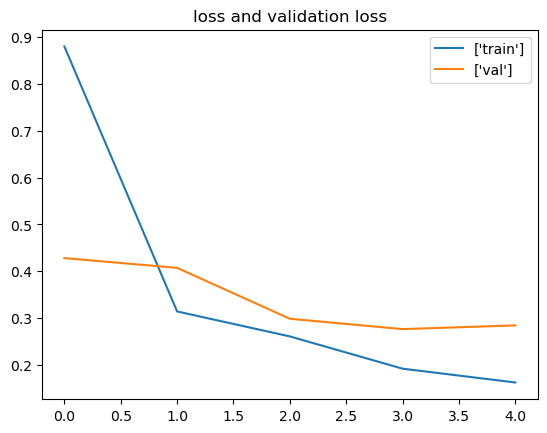

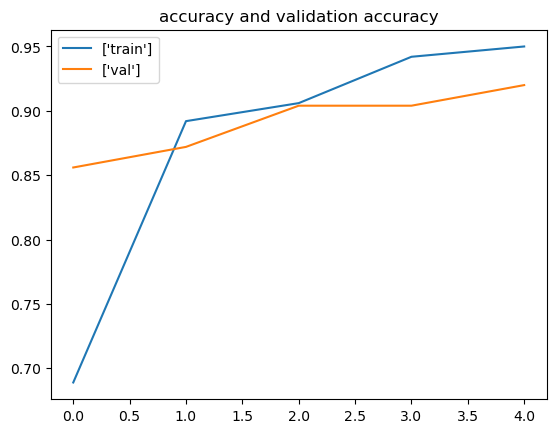

In [7]:
plt.plot(history.history['loss'], label=['train']) #loss de train
plt.plot(history.history['val_loss'], label=['val']) # loss de test
plt.title('loss and validation loss') # title
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label=['train']) #loss de train
plt.plot(history.history['val_accuracy'], label=['val']) # loss de test
plt.title('accuracy and validation accuracy') # title
plt.legend()
plt.show()

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_set)
print('Test accuracy:', test_acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - accuracy: 0.9591 - loss: 0.1387
Test accuracy: 0.9679999947547913


In [9]:
model.save('AID_VGG16_DATASET1_CNN.h5')